In [ ]:
# !pip install -U --pre pystac
# !pip install --no-deps radiant_mlhub

## Data Access

We're using training data from the [South Africa Crop Type Competition](https://registry.mlhub.earth/10.34911/rdnt.j0co8q/). It's based on Sentinel-2 Imagery, which we'll access from the Planetary Computer's STAC API.

We'll have a STAC collection, with a few items:

In [1]:
import pystac
import pystac_client

In [4]:
training_catalog = pystac.read_file("https://esip2021.blob.core.windows.net/esip2021/train/collection.json")
training_catalog

<Collection id=ref_south_africa_crops_competition_v1_train_labels>

In [36]:
label_items = list(training_catalog.get_all_items())

Let's grab an item.

In [37]:
label_item = label_items[18]

That item has some assets pointing to files like the documentation, parent collection, and the TIFF with the labels. We'll load the labels into a DataArray:

In [38]:
import rioxarray

labels = rioxarray.open_rasterio(label_item.assets['labels'].get_absolute_href()).squeeze()
labels

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
  * y            (y) float64 -3.602e+06 -3.602e+06 ... -3.604e+06 -3.604e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

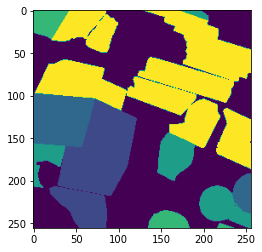

In [39]:
import rasterio.plot

rasterio.plot.show(labels);

That item is from a specific date / time.

In [40]:
label_item.datetime

datetime.datetime(2017, 8, 1, 0, 0, tzinfo=tzlocal())

In [41]:
label_item.geometry

{'coordinates': [[[18.46447947403402, -32.552189271279396],
   [18.491720494381838, -32.55273603831489],
   [18.49236223306772, -32.529664371949366],
   [18.465128164182214, -32.529118087556135],
   [18.46447947403402, -32.552189271279396]]],
 'type': 'Polygon'}

We'll search for Sentinel-2 scenes intersecting with that item from around that datetime

In [42]:
import pystac_client

stac = pystac_client.Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1/")

search = stac.search(collections=["sentinel-2-l2a"], intersects=label_item.geometry, limit=500, datetime="2017-07-01/2017-09-01")

Let's find a scene with few clouds:

In [43]:
items = list(search.get_all_items())
sentinel_item = sorted(items, key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover)[0]

In [44]:
# TODO: Use z/y/z tileserver thing instead of embedding an IFrame.
# Then throw the geometry of the label_item on there
from IPython.display import IFrame
IFrame(sentinel_item.get_links(rel="preview")[0].href, 1200, 800)

We have a bit of work to align the training labels and the image. First, the epsg doesn't match.

In [45]:
labels.rio.crs

CRS.from_epsg(32634)

In [46]:
proj = pystac.extensions.projection.ProjectionExtension.ext(sentinel_item.assets["B02"])
proj.epsg

32734

In [47]:
labels2 = labels.rio.reproject(proj.epsg)
labels2

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]], dtype=uint8)
Coordinates:
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
  * y            (y) float64 6.398e+06 6.398e+06 ... 6.396e+06 6.396e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    0

In [48]:
bounds = tuple(round(x, 0) for x in labels2.rio.bounds())
bounds

(261920.0, 6395520.0, 264480.0, 6398080.0)

Now we can load the training data into a DataArray, trimming down that large scene to just those intersecting with our small patch.

In [49]:
import planetary_computer
import stackstac

assets = ["B02", "B03", "B04", "B05", "B06", "B07", "B09"]
data = stackstac.stack(planetary_computer.sign(sentinel_item).to_dict(), assets=assets, dtype="float32", resolution=10, bounds=bounds).where(lambda x: x > 0).squeeze()

assert data.shape[1:] == labels2.shape

data = data.compute()
data

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/accumulate_metadata.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  props_arr = np.squeeze(np.array(props))


<xarray.DataArray 'stackstac-3f48e5f918d28d8961574a3a152e2ac8' (band: 7, y: 256, x: 256)>
array([[[ 589.,  573.,  533., ...,  901.,  377.,  526.],
        [ 437.,  443.,  438., ...,  857.,  643.,  520.],
        [ 379.,  410.,  434., ...,  883.,  773.,  513.],
        ...,
        [ 480.,  517.,  455., ...,  888.,  948.,  730.],
        [ 344.,  504.,  469., ...,  724.,  760.,  620.],
        [ 120.,  277.,  260., ...,  652.,  673.,  608.]],

       [[1176., 1156., 1152., ..., 1246.,  608.,  732.],
        [1110., 1084., 1106., ..., 1266.,  750.,  708.],
        [1021., 1072., 1092., ..., 1158., 1232.,  730.],
        ...,
        [ 589.,  659.,  600., ..., 1234., 1344., 1128.],
        [ 394.,  647.,  618., ..., 1294., 1256., 1042.],
        [ 182.,  325.,  353., ...,  989., 1068.,  961.]],

       [[1004.,  932.,  897., ..., 1632.,  777.,  962.],
        [ 780.,  780.,  750., ..., 1518., 1152.,  933.],
        [ 654.,  747.,  713., ..., 1568., 1404.,  965.],
        ...,
...
        ...,
        [1260., 1260., 1374., ..., 2796., 2827., 2827.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.]],

       [[4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4765., 4765., 4769., ..., 1880., 1963., 1963.],
        ...,
        [1315., 1315., 1397., ..., 3045., 2952., 2952.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.]],

       [[4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        ...,
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.]]], dtype=float32)
Coordinates: (12/46)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * band                                     (band) <U3 'B02' 'B03' ... 'B09'
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
  * y                                        (y) float64 6.398e+06 ... 6.396e+06
    s2:mean_solar_azimuth                    float64 32.11
    ...                                       ...
    proj:shape                               (band) object None ... [1830, 1830]
    proj:transform                           (band) object None ... [60.0, 0....
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) float64 0.49 0.56 ... 0.945
    full_width_half_max                      (band) float64 0.098 ... 0.026
    epsg                                     int64 32734
Attributes:
    spec:        RasterSpec(epsg=32734, bounds=(261920, 6395520, 264480, 6398...
    crs:         epsg:32734
    transform:   | 10.00, 0.00, 261920.00|\n| 0.00,-10.00, 6398080.00|\n| 0.0...
    resolution:  10

Our shapes match (256 x 256 patch), but the labels don't quite. They're off by half a pixel (5 units in coordinate space).

In [50]:
labels2.x

<xarray.DataArray 'x' (x: 256)>
array([261925., 261935., 261945., ..., 264455., 264465., 264475.])
Coordinates:
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
    band         int64 1
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre

In [51]:
data.x

<xarray.DataArray 'x' (x: 256)>
array([261920., 261930., 261940., ..., 264450., 264460., 264470.])
Coordinates: (12/37)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
    s2:mean_solar_azimuth                    float64 32.11
    s2:generation_time                       <U24 '2021-02-10T15:52:59.380Z'
    s2:datastrip_id                          <U64 'S2B_OPER_MSI_L2A_DS_ESRI_2...
    ...                                       ...
    s2:granule_id                            <U62 'S2B_OPER_MSI_L2A_TL_ESRI_2...
    eo:cloud_cover                           float64 0.08305
    instruments                              <U3 'msi'
    s2:vegetation_percentage                 float64 3.018
    proj:bbox                                object {6500020.0, 6390220.0, 19...
    epsg                                     int64 32734

In [52]:
labels3 = (
    labels2.assign_coords(
        y=lambda ds: (ds.y + 5).round(),   # fix half-pixel label issue
        x=lambda ds: (ds.x - 5).round(),
    )
)

Now we should be all set.

In [53]:
assert (data.x == labels2.x).all()
assert (data.y == labels2.y).all()

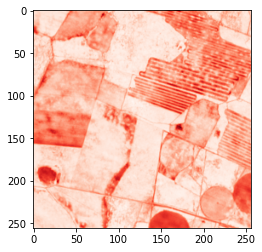

In [54]:
rasterio.plot.show(data.sel(band="B04"), cmap="Reds");

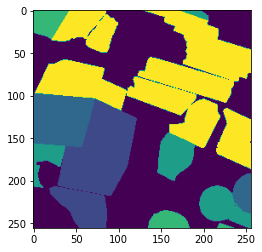

In [55]:
rasterio.plot.show(labels);

## Baseline

We'll use a scikit-learn K-Nearest Neighbors classifier to establish a baseline on this image. First, we need to reshape to `(n_samples, n_features)` by stacking all the the pixels into one long array. The features will be each band from the sensor.

In [56]:
X = data.stack(pixel=("y", "x")).T
X.shape

(65536, 7)

We'll also reshape the labels to be a 1-D array `(n_features,)`

In [57]:
y = labels3.stack(pixel=("y", "x"))

In [58]:
assert X.indexes['pixel'].equals(y.indexes['pixel'])

In [59]:
import sklearn.neighbors
import sklearn.model_selection

In [60]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [61]:
nn = sklearn.neighbors.KNeighborsClassifier()
%time nn.fit(X_train, y_train)

CPU times: user 63 ms, sys: 0 ns, total: 63 ms
Wall time: 74 ms


KNeighborsClassifier()

In [62]:
%time nn.score(X_train, y_train)

CPU times: user 2.73 s, sys: 6.84 ms, total: 2.73 s
Wall time: 2.74 s


0.8935750325520834

In [63]:
%time nn.score(X_test, y_test)

CPU times: user 971 ms, sys: 3.43 ms, total: 974 ms
Wall time: 975 ms


0.84356689453125

84% on our "test" set, which will still look a ton like our data. This probably won't generalize to other scenes.

In [65]:
yhat = nn.predict(X)

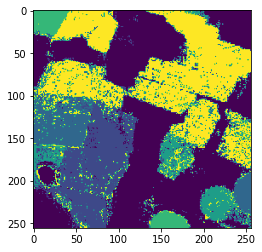

In [66]:
import xarray as xr

rasterio.plot.show(xr.DataArray(yhat.reshape(labels3.shape), coords=labels3.coords, dims=labels3.dims));

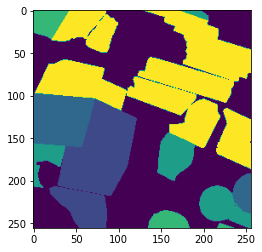

In [67]:
rasterio.plot.show(labels);

Not *awful*, but certainly room for improvement. At this point, we would either move to a more sophisticated model, or train this model on more data, or both.